In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2

def load_and_normalize_images(base_folder_path, class_labels):
    all_sequences = []
    all_labels = []

    for class_folder, label in class_labels.items():
        class_path = os.path.join(base_folder_path, class_folder)

        sequence_folders = [f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f))]

        for sequence_folder in sequence_folders:
            sequence_path = os.path.join(class_path, sequence_folder)

            file_names = os.listdir(sequence_path)
            sorted_files = sorted(file_names, key=lambda x: int(os.path.splitext(x)[0]))

            images = []

            for file_name in sorted_files:
                file_path = os.path.join(sequence_path, file_name)
                image = Image.open(file_path)
                image_array = np.array(image) / 255.0  # Normalizar
                images.append(image_array)
            images = np.array(images) 
            all_sequences.append(images)
            all_labels.append(label)

    all_sequences = np.array(all_sequences)  
    all_labels = np.array(all_labels)  
    
    return all_sequences, all_labels

def display_sequences(sequences, num_sequences_to_show=5):
    for sequence in sequences[:num_sequences_to_show]:
        fig, axes = plt.subplots(1, len(sequence), figsize=(20, 20))
        for i, image in enumerate(sequence):
            if len(sequence) == 1:
                ax = axes
            else:
                ax = axes[i]
            ax.imshow(image)
            ax.axis('off')
        plt.show()

class_labels = {
    "neutral": 0,
    "frustration": 1
    
}



In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [3]:
class SequenceDataGenerator(Sequence):
    def __init__(self, directory, batch_size, img_size, sequence_length, shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_length = sequence_length
        self.shuffle = shuffle
        self.class_names = sorted(os.listdir(directory))
        self.samples = self._load_samples()
        self.on_epoch_end()
        
    def _load_samples(self):
        samples = []
        for class_name in self.class_names:
            class_dir = os.path.join(self.directory, class_name)
            for sequence_name in os.listdir(class_dir):
                sequence_dir = os.path.join(class_dir, sequence_name)
                frames = sorted(os.listdir(sequence_dir))
                samples.append((sequence_dir, frames, self.class_names.index(class_name)))
        return samples
    
    def __len__(self):
        return int(np.floor(len(self.samples) / self.batch_size))
    
    def __getitem__(self, index):
        batch_samples = self.samples[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self._generate_data(batch_samples)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.samples)
    
    def _generate_data(self, batch_samples):
        X = np.zeros((self.batch_size, self.sequence_length, *self.img_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size,), dtype=int)  # Aquí se cambia np.int por int
        
        for i, (sequence_dir, frames, label) in enumerate(batch_samples):
            for j, frame_name in enumerate(frames[:self.sequence_length]):
                img_path = os.path.join(sequence_dir, frame_name)
                img = load_img(img_path, target_size=self.img_size)
                img_array = img_to_array(img) / 255.0
                X[i, j, :, :, :] = img_array
            y[i] = label
        
        return X, y



In [4]:
train_dir = 'up-close-reshaped-224/train'
val_dir = 'up-close-reshaped-224/dev'
test_dir = 'up-close-reshaped-224/test'

batch_size = 32
img_size = (224, 224)
sequence_length = 30

train_gen = SequenceDataGenerator(train_dir, batch_size, img_size, sequence_length)
val_gen = SequenceDataGenerator(val_dir, batch_size, img_size, sequence_length)
test_gen = SequenceDataGenerator(test_dir, batch_size, img_size, sequence_length, shuffle=False)


In [5]:
def show_first_sequences(generator, num_sequences=5):
    class_names = generator.class_names
    sequences_shown = 0
    
    for X, y in generator:
        for j in range(min(generator.batch_size, num_sequences - sequences_shown)):
            plt.figure(figsize=(15, 3))
            for k in range(generator.sequence_length):
                plt.subplot(1, generator.sequence_length, k + 1)
                plt.imshow(X[j, k])
                plt.axis('off')
            plt.suptitle(f'Sequence {sequences_shown + 1}, Label: {class_names[y[j]]} , {y[j]}')
            plt.show()
            sequences_shown += 1
            if sequences_shown >= num_sequences:
                return

Primeras 5 secuencias del conjunto de entrenamiento:


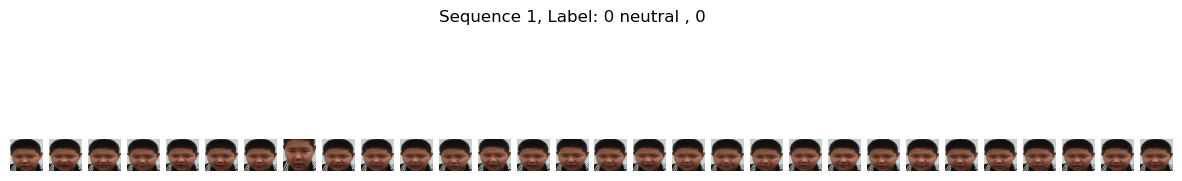

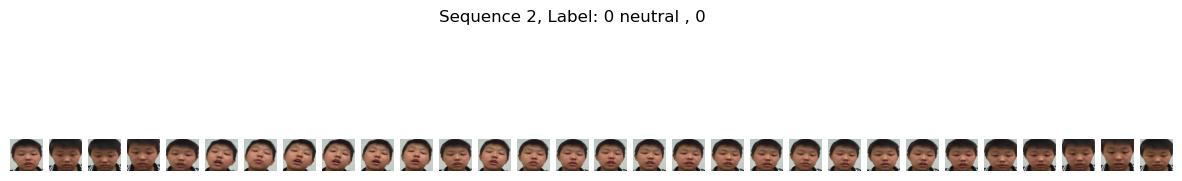

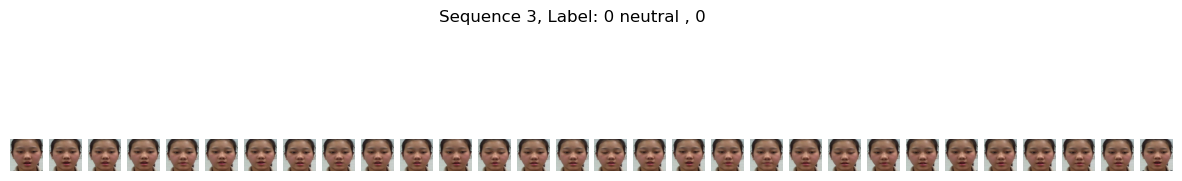

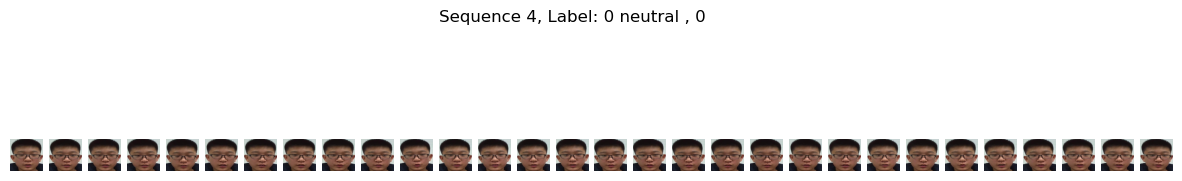

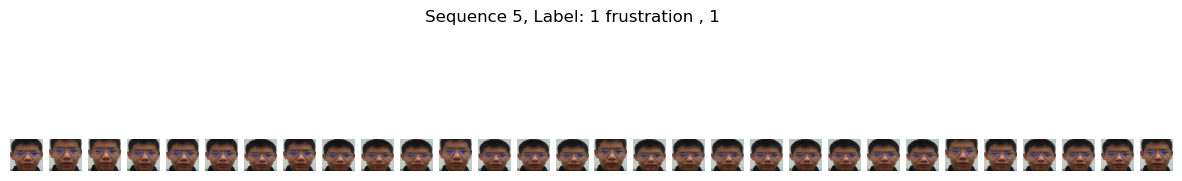

In [6]:
print("Primeras 5 secuencias del conjunto de entrenamiento:")
show_first_sequences(train_gen)

In [7]:
height = 64
width = 64
channels = 3
sequence_length = 30

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed,Dropout,BatchNormalization,LSTM,Dense

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(30,224, 224, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.5))) 

model.add(TimeDistributed(Flatten()))

model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 222, 222, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 111, 111, 16)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 109, 109, 32)  4640     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 54, 54, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 52, 52, 32)   9

In [10]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [21]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [13]:
history = model.fit(train_gen, epochs=10, batch_size=32, validation_data=val_gen,callbacks=[early_stopping, reduce_lr])

Epoch 1/10
222/222 [==============================] - 2319s 10s/step - loss: 0.5572 - accuracy: 0.7116 - val_loss: 0.9229 - val_accuracy: 0.3422 - lr: 0.0010
Epoch 2/10
222/222 [==============================] - 2236s 10s/step - loss: 0.3869 - accuracy: 0.8329 - val_loss: 0.4292 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 3/10
222/222 [==============================] - 2232s 10s/step - loss: 0.3155 - accuracy: 0.8725 - val_loss: 0.3601 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 4/10
222/222 [==============================] - 2458s 11s/step - loss: 0.2599 - accuracy: 0.8998 - val_loss: 0.3796 - val_accuracy: 0.8445 - lr: 0.0010
Epoch 5/10
222/222 [==============================] - 2425s 11s/step - loss: 0.2102 - accuracy: 0.9231 - val_loss: 0.2368 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 6/10
222/222 [==============================] - 2384s 11s/step - loss: 0.1701 - accuracy: 0.9383 - val_loss: 0.2989 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 7/10
222/222 [==============================] 

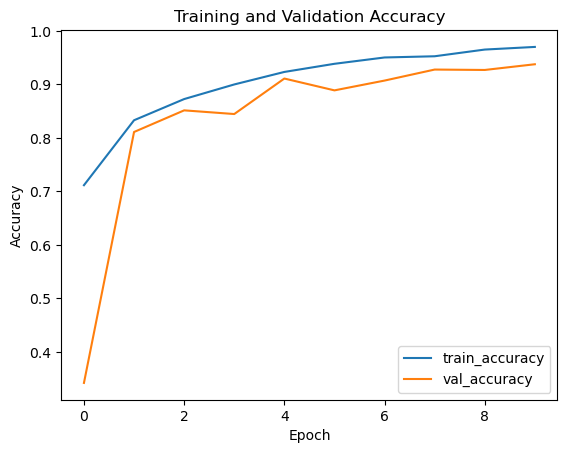

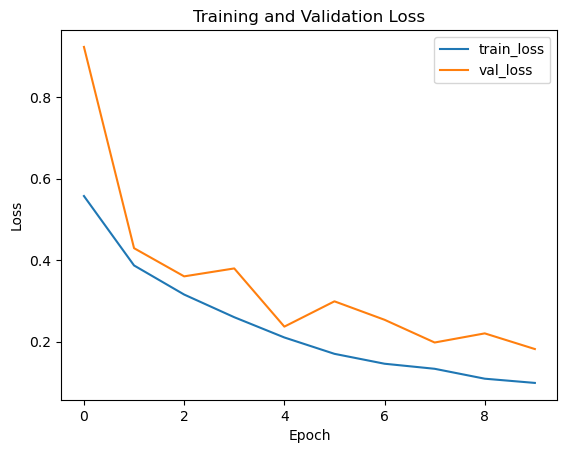

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
model.save('cnn-lstm-fds-1.h5')

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

5/5 [==============================] - 8s 1s/step - loss: 0.4118 - accuracy: 0.8722
Accuracy: 87.22%


In [17]:
from tensorflow.keras.utils import to_categorical

In [18]:
num_classes = len(np.unique(X_test))
test_labels = to_categorical(y_test, num_classes=num_classes)

In [19]:
predictions = model.predict(X_test)

print(predictions.shape) 


predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

5/5 [==============================] - 8s 1s/step
(133, 2)


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

1/1 [==============================] - 2s 2s/step


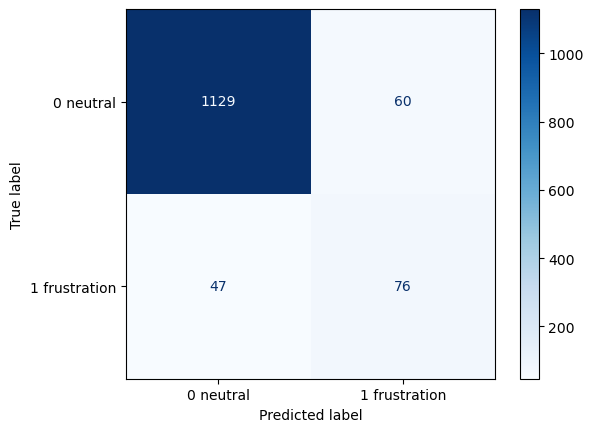

In [25]:
y_true = []
y_pred = []

for X, y in test_gen:
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(y)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_gen.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [19]:
predicted_labels = np.argmax(predictions, axis=1)

AttributeError: 'SequenceDataGenerator' object has no attribute 'labels'

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(test_gen, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(2), yticklabels=np.arange(2))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [41, 1312]

In [20]:
from sklearn.metrics import recall_score, f1_score

recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Recall: 0.8721804511278195
F1 Score: 0.852703186537773


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [25]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     neutral       0.90      0.96      0.93       119
 frustration       0.29      0.14      0.19        14

    accuracy                           0.87       133
   macro avg       0.60      0.55      0.56       133
weighted avg       0.84      0.87      0.85       133



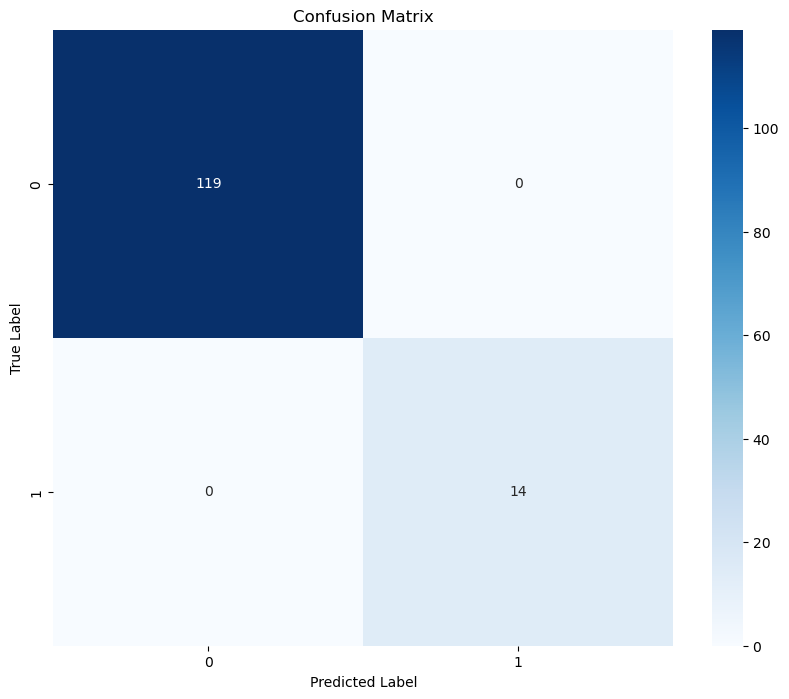

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, true_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()